In [1]:
from modules.words import *

[nltk_data] Downloading package wordnet to /home/laura/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/laura/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Dataset creation

Once the words are extracted, they are stored in a Pandas DataFrame with the following attributes:

1. <code> id </code> : Reference to the tweet ID
2. <code> index </code> : Position of the word in the sentence (tweet) - useful to delete self loops
3. <code> text </code> : Actual word
4. <code> pos </code> : Part Of Speech tag
5. <code> conf </code> : Confidence associated to the POS tag

Words dataframe

                     id  index    text pos    conf
0  1013189209488797697      0   pride   N  0.5711
1  1013189209488797697      1   month   N  0.9439
2  1013189209488797697      2     may   V  0.9752
3  1013189209488797697      3      be   V  0.9994
4  1013189209488797697      4  ending   V  0.9888



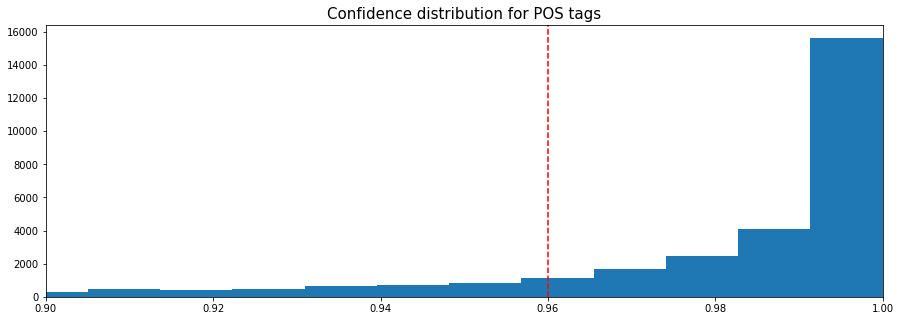

There are 11624 (32.08%) words under 0.96 confidence interval
There will be 24611 (67.92%) words remaining inside 0.96 confidence interval


Final number of words (after cleaning):  20590


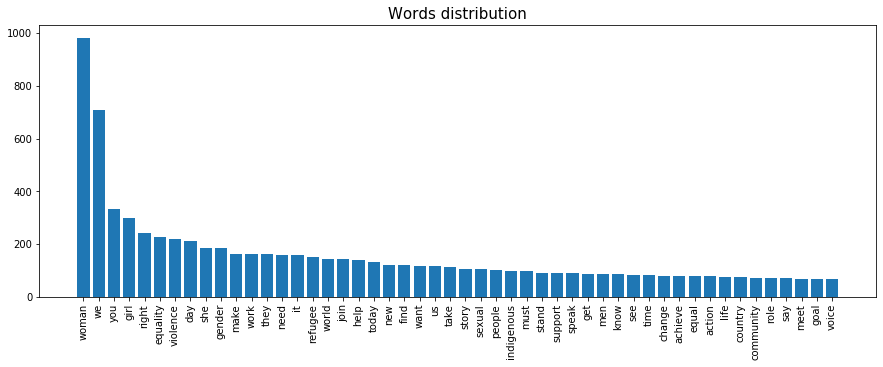

In [2]:
extraction('metoo', 0.96)

Words dataframe

                     id  index         text pos    conf
0  1006327664976617472      1          new   A  0.9980
1  1006327664976617472      2        paper   N  0.9881
2  1006327664976617472      5        shows   V  0.9870
3  1006327664976617472      7  temperature   N  0.9922
4  1006327664976617472      8        goals   N  0.9671



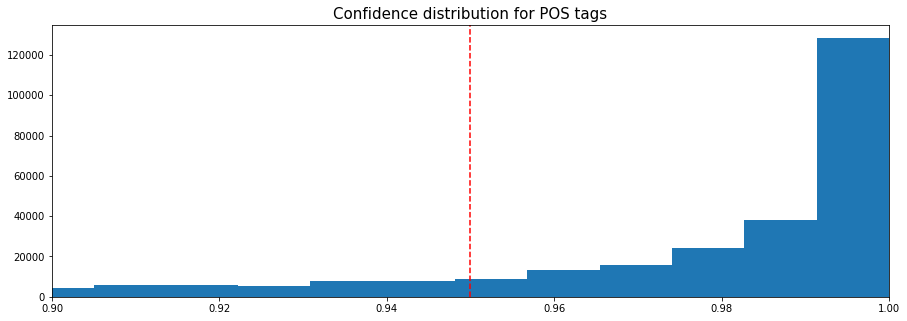

There are 110121 (32.68%) words under 0.95 confidence interval
There will be 226884 (67.32%) words remaining inside 0.95 confidence interval


Final number of words (after cleaning):  190097


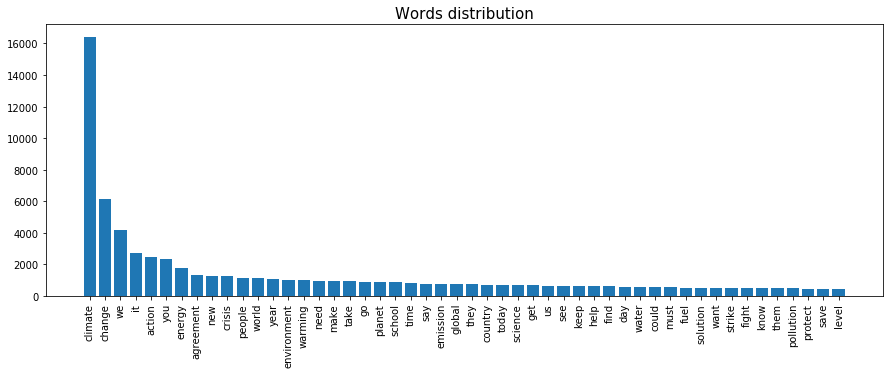

In [3]:
extraction('greta', 0.95)